# Implementation 02 (SNOPT)
`1011.30.Mar.20`

Now that I have the constraints set up (Both the new boundary and the function determining if a turbine is "in"), I can try and feed that into [SNOPT](https://web.stanford.edu/group/SOL/snopt.htm) to actually get an optimization. I will also need to use  SNOPT for my old system as well.

### Setting up my desktop

`1255.01.Apr.20`

I had some trouble finding examples of implementation code.
I today reached out to PJ and he gave some sample code.
I'm going over it now.

#### PJ's code

```python
from pyoptsparse import Optimization, SNOPT, pyOpt_solution, NSGA2
import numpy as np
import matplotlib.pyplot as plt
from position_constraints import *
from windRoses import *
from grid_param_test import *
from aep_calc import *
import scipy as sp
import os
import sys
sys.dont_write_bytecode = True
def obj_func_grid(xdict):
    global rotorDiameter
    global turbineZ
    global windDirections
    global windSpeeds
    global windFrequencies
    global shearExp
    global minSpacing
    global nTurbs
    global boundaryVertices
    global boundaryNormals
    global circle_radius
    global rf
    global wakemodel
    global nRows
    global turbs_per_row
    global x_start
    global anchor_x
    global anchor_y
    global nCalls
    nCalls += 1
    dx = xdict['dx']
    dy = xdict['dy']
    offset = xdict['offset']
    rotate = xdict['rotate']
    # scale = xdict['scale']
    scale = 1.0
    turbineX,turbineY = makeGrid_centered(dx,dy,offset,rotate,turbs_per_row,x_start)
    if nCalls == 1:
        print turbineX
        print turbineY
    show = False
    if show == True:
        plt.figure(1)
        plt.clf()
        for i in range(nTurbs):
            circ = plt.Circle((turbineX[i],turbineY[i]), rotorDiameter[i]/2.,facecolor="blue",edgecolor="blue",alpha=0.2)
            plt.gca().add_patch(circ)
        # circ = plt.Circle((0.,0.), circle_radius,facecolor="None",edgecolor="black",alpha=0.8)
        # plt.plot(np.array([-1800.,-1800.,1800.,1800.,-1800]),np.array([-1800.,1800.,1800.,-1800.,-1800.]),'-k')
        # plt.gca().add_patch(circ)
        # plt.xlim(-2200.,2200.)
        xb = boundaryVertices[:,0]
        yb = boundaryVertices[:,1]
        xb = np.append(xb,xb[0])
        yb = np.append(yb,yb[0])
        plt.plot(xb,yb,'--k')
        plt.axis('equal')
        plt.axis('off')
        plt.draw()
        plt.pause(0.001)
    funcs = {}
    AEP = fast_calc_AEP(turbineX, turbineY, turbineZ, rotorDiameter, windDirections,
                windSpeeds, windFrequencies, wakemodel=wakemodel,relaxationFactor=rf)
    print -AEP/1.E5
    funcs['obj'] = -AEP/1.E5
    funcs['sep'] = SpacingConstraint(turbineX, turbineY, rotorDiameter, minSpacing=minSpacing)/1.E5
    bounds = arbitraryBoundary(turbineX, turbineY, boundaryVertices, boundaryNormals)/1.E3
    b = np.zeros(np.shape(bounds)[0])
    for i in range(len(b)):
        b[i] = min(bounds[i])
    funcs['bound'] = b
    fail = False
    return funcs, fail
## Main
if __name__ == "__main__":
    global rotorDiameter
    global turbineZ
    global windDirections
    global windSpeeds
    global windFrequencies
    global shearExp
    global minSpacing
    global nTurbs
    global boundaryVertices
    global boundaryNormals
    global circle_radius
    global rf
    global wakemodel
    global nRows
    global turbs_per_row
    global x_start
    global anchor_x
    global anchor_y
    global nCalls
    wakemodel = "gaussian"
    nTurbs = 100
    rose = 'ukiah'
    windDirections, windFrequencies, windSpeeds = ukiahRose(30)
    wind_angle = windDirections[np.argmax(windFrequencies)]
    windDirections, windFrequencies, windSpeeds = ukiahRose(30,nSpeeds=8)
    windDirections -= wind_angle
    turbineZ = np.ones(nTurbs)*100.
    rotorDiameter = np.ones(nTurbs)*130.
    shearExp = 0.15
    minSpacing = 2.0
    maxAEP = 0.
    spacing = 4.
    side_length = (np.sqrt(nTurbs)-1.)*rotorDiameter[0]*spacing
    a = side_length**2
    circle_radius = np.sqrt(a/np.pi)
    # folder = 'grid_square_%s_%s_%s_%s'%(nTurbs,spacing,rose,wakemodel)
    # folder = 'grid4_square_%s_%s_%s_%s'%(nTurbs,spacing,rose,wakemodel)
    #
    # if not os.path.exists(folder):
    #     os.makedirs(folder)
    """circle boundary"""
    nBounds = 20
    # circle_radius = 5280.
    xBounds = np.zeros(nBounds)
    yBounds = np.zeros(nBounds)
    theta = np.linspace(0.,2.*np.pi-2.*np.pi/float(nBounds),nBounds)
    for i in range(nBounds):
        xBounds[i] = circle_radius*np.cos(theta[i])
        yBounds[i] = circle_radius*np.sin(theta[i])
    x = np.zeros_like(xBounds)
    x[:] = xBounds[:]
    y = np.zeros_like(yBounds)
    y[:] = yBounds[:]
    xBounds = x*np.cos(np.deg2rad(wind_angle)) - y*np.sin(np.deg2rad(wind_angle))
    yBounds = x*np.sin(np.deg2rad(wind_angle)) + y*np.cos(np.deg2rad(wind_angle))
    """square boundary rotated 30 deg from dominant wind direction"""
    # nBounds = 4
    # x = np.array([-side_length/2.,side_length/2.,side_length/2.,-side_length/2.])
    # y = np.array([-side_length/2.,-side_length/2.,side_length/2.,side_length/2.])
    # xBounds = x*np.cos(np.deg2rad(30.)) - y*np.sin(np.deg2rad(30.))
    # yBounds = x*np.sin(np.deg2rad(30.)) + y*np.cos(np.deg2rad(30.))
    # locations = np.zeros((nBounds,2))
    # locations[:, 0] = xBounds
    # locations[:, 1] = yBounds
    # boundaryVertices, boundaryNormals = calculate_boundary(locations)
    """amalia boundary"""
    # locations = np.loadtxt('layout_amalia.txt')
    # xBounds = locations[:, 0]
    # yBounds = locations[:, 1]
    # xBounds = xBounds - min(xBounds) - (max(xBounds)-min(xBounds))/2.
    # yBounds = yBounds - min(yBounds) - (max(yBounds)-min(yBounds))/2.
    # locations[:, 0] = xBounds
    # locations[:, 1] = yBounds
    # boundaryVertices, boundaryNormals = calculate_boundary(locations)
    # xBounds = boundaryVertices[:, 0]
    # yBounds = boundaryVertices[:, 1]
    nBounds = len(xBounds)
    points = np.zeros((nBounds,2))
    points[:, 0] = xBounds
    points[:, 1] = yBounds
    # hull = sp.spatial.ConvexHull(points)
    # area = hull.volume
    # area_ratio = area/(np.pi*circle_radius**2)
    # xBounds = xBounds/np.sqrt(area_ratio)
    # yBounds = yBounds/np.sqrt(area_ratio)
    # points[:, 0] = xBounds
    # points[:, 1] = yBounds
    # boundaryVertices, boundaryNormals = calculate_boundary(points)
    xBounds = np.append(xBounds,xBounds[0])
    yBounds = np.append(yBounds,yBounds[0])
    dx_start,dy_start,offset_start,rotate_start,turbs_per_row,x_start = make_start_grid_test(nTurbs,boundaryVertices,boundaryNormals)
    factors = np.array([3.0,2.75,2.5,2.25,2.0,1.75,1.5,1.25,1.0])
    rf = 1.0
    num = 1
    nCalls = 0
    for i in range(num):
        print 'iterations: ', i
        # dx = float(np.random.rand(1))*dx_start+200.
        # dy = float(np.random.rand(1))*dy_start+200.
        # offset = float(np.random.rand(1))*25.+10.
        # rotate = float(np.random.rand(1))*30.-15.
        dx = dx_start
        dy = dy_start
        offset = offset_start
        rotate = rotate_start
        input = {'dx':dx,'dy':dy,'offset':offset,'rotate':rotate}
        funcs,_ = obj_func_grid(input)
        AEPstart = funcs['obj']
        print AEPstart
        nCalls = 0
        """Optimization"""
        optProb = Optimization('Wind_Farm_AEP', obj_func_grid)
        optProb.addObj('obj')
        optProb.addVar('dx', type='c', lower=0., upper=None, value=dx)
        optProb.addVar('dy', type='c', lower=0., upper=None, value=dy)
        optProb.addVar('offset', type='c', lower=None, upper=None, value=offset)
        optProb.addVar('rotate', type='c', lower=None, upper=None, value=rotate)
        num_cons_sep = (nTurbs-1)*nTurbs/2
        optProb.addConGroup('sep', num_cons_sep, lower=0., upper=None)
        optProb.addConGroup('bound', nTurbs, lower=0., upper=None)
        opt = SNOPT()
        opt.setOption('Scale option',0)
        opt.setOption('Iterations limit',1000000)
        opt.setOption('Summary file','summary_grid.out')
        opt.setOption('Major optimality tolerance',1.e-5)
        opt.setOption('Major feasibility tolerance',1.e-6)
        res = opt(optProb)
        dx_f = res.xStar['dx']
        dy_f = res.xStar['dy']
        o_f = res.xStar['offset']
        r_f = res.xStar['rotate']
        # print 'dx_f: ', dx_f
        # print 'dy_f: ', dy_f
        # print 'offset_f: ', o_f
        # print 'rotate_f: ', r_f
        print nCalls
        input = {'dx':dx_f,'dy':dy_f,'offset':o_f,'rotate':r_f}
        funcs,_ = obj_func_grid(input)
        separation = min(funcs['sep'])
        boundary = min(funcs['bound'])
        if separation > -1.E-4 and boundary > -1.E-4 and -funcs['obj'] > maxAEP:
            maxAEP = -funcs['obj']
        if separation > -1.E-4 and boundary > -1.E-4:
            print 'AEP opt: ', -funcs['obj']
            # file = open('%s/AEP.txt'%folder, 'a')
            # file.write('%s'%(-funcs['obj']) + '\n')
            # file.close()
            #
            # file = open('%s/funcCalls.txt'%folder, 'a')
            # file.write('%s'%nCalls + '\n')
            # file.close()
        print 'maxAEP: ', maxAEP
    print 'final maxAEP: ', maxAEP
    plt.show()
```

### More work

`1357.01.Apr.20`

I had an issue with installing pyOptSparse - I thought I had on monday, but apparently not.
I think the issue was I installed Python 3 on this windows machine, but the FLOWLab only works in Python 2, so I needed to install that and change the environment with `activate py2` and `deactivate`.
It's completing the installation now, we'll see if it worked.

`1307.03.Apr.20`

I had to restart my system and apparently lost the last few days of logs, but it wasn't much. I've been trying to install SNOPT on my windows system and it just isn't working. I've got to call it at this point and move over to my laptop for working.

`1419.03.Apr.20`

I prefer my keyboard, mouse, and monitor, and the laptop just can't connect to all those devices. Instead of buying yet another adapter, I opted to go with Chrome's remote desktop extension. It allows me to remote in to the macbook (there's a bit of lag), but I can code and run everything on here, while still using my main desktop for internet, background music, and everything else.

## Order of Events

Ok I have the constraint functions set, I want to do 3 things from here out:

1. Get SNOPT to optimize the smaller Dr. Ning area
2. Get SNOPT to optimize my original full area
3. Get my mapping algorithm working

## SNOPT on Dr. Ning's area

`0834.06.Apr.20`

First I'll need to run the test files that wouldn't work on my desktop.

`1259.08.Apr.2020`

After conversing with Dr.~Ning, he told me since the lab has an old version of SNOPT, I need to retrograde and download an old version of [PyOptSparse](www.github.com/mdolab/pyoptsparse). After looking through the release history I installed [v1.2](https://github.com/mdolab/pyoptsparse/releases/tag/v1.2). The NLPQLP test failed, but at least the SNOPT test finally passed, so I'll keep moving forward. This took entirely too long to figure out.

First thing to do is look at PJ's sample code that he gave me last week. (in markdowned code block below).

`1756.08.Apr.20`

I also am using a tutorial from [the pyOpt website](www.pyopt.org/tutorial).
We'll see how it works.


### Helper functions for formatting

In [70]:
#- Rip the boundary coordinates from the .yaml file and print -#
from scipy.optimize import minimize
import random

%run "../baker_cs34_functions.py"
%run "../iea37_aepcalc.py"
fn = "../../startup-files/iea37-boundary-cs3.yaml"
bndryPts = getTurbAtrbtCs3YAML(fn)
coordList = closeBndryList(bndryPts)    # Duplicate the first coordinate for a closed boundary

In [40]:
#-- Plot the boundary (modelled with splines) --#
numLinspace = 10
numGridLines = 10                   # How many gridlines we'll use for the visualization
printOffset = (5, 5)
clsdBP = closeBndryList(bndryPts)
fMinDist = 2*turb_diam
vertexList = [0, 6, 8, 9, 18]       # Hard code the vertices (though this could be done algorithmically)
numSides = len(vertexList) - 1      # The number of sides for our original coordinate system. Usually (4) to Euclidean, but could be any number)

scaleAEP = 1e5
scaleTurbCoord = 1e3

#-- Spline the boundary --#
splineList = np.empty(numSides, interp1d)                  # Init. array IOT save the Splines for each "side"
buf = np.zeros((numSides, numGridLines, 2))                # Used to initalize the recarray to zeros
segCoordList = np.recarray([numSides, numGridLines], dtype=coordinate, buf=buf)

#- Create the splines for each side (<numSides> many)-#
for i in range(numSides):
    BndPts = clsdBP[vertexList[i]:(vertexList[i+1]+1)]      # Extract the points for the "edge" we want
    segCoordList[i] = sliceBoundary(BndPts, numGridLines)    # Reparameterize the boundry to be defined by <numGridLines> many points
    splineList[i] = interp1d(segCoordList[i].x, segCoordList[i].y, kind='linear')   # Make the spline using NumPy's <interp1d>
    
print("The splined boundary and the defining coordinates:")
##for i in range(numSides):
#    plt.hold = True
#    printBoundaryArray(segCoordList[i].x, splineList[i](segCoordList[i].x), displaySize, 1)

##for i in vertexList:                         # Number the vertices
#for i in range(len(clsdBP)):                         # Number the vertices
#    plt.plot(clsdBP[i].x, clsdBP[i].y, 'o', color=(getPltClrs().getColor(5)))
#    plt.annotate(i, (clsdBP[i].x, clsdBP[i].y), xytext=printOffset, textcoords='offset points')

The splined boundary and the defining coordinates:


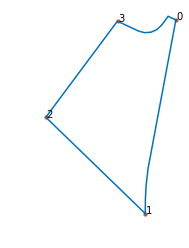

In [8]:
vertexPts = bndryPts[vertexList[0:4]]

colorNum = 5
printBoundaryClr(clsdBP, colorNum)
printTurbines(vertexPts, getPltClrs().getColor(6), 10, True)

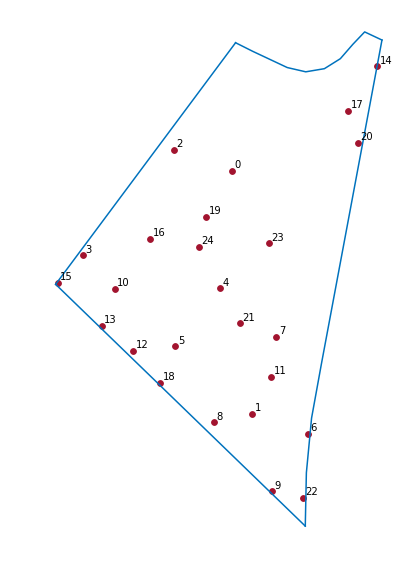

In [73]:
#-- Testing --#
numTurbs = 25
turb_diam = 198.0
vertexPts = bndryPts[vertexList[0:4]]  # Make an array of just the four "vertex" points we're using
turbRandoList = iea37cs3randomstarts(numTurbs, splineList, vertexPts, fMinDist)

#-- Print the random turbine locations (with numbers) --#
#-- Plot the boundary --#
plt.figure(figsize=(20,10))
for i in range(numSides):
    plt.hold = True
    printBoundaryArray(segCoordList[i].x, splineList[i](segCoordList[i].x), 5)

#-- Plot the turbine locations --#
printTurbines(turbRandoList, getPltClrs().getColor(1), turb_diam/6, True)
#-- End print of turbine locations--#

### Retest of notebook `bakerIEA37cs3-10-cs3workout`

`1601.14.Apr.20`

The following is making sure the functions written in notebook `10` carried over when saved into the `sandbox` header file. I just call the functions and ensure they give the same output:

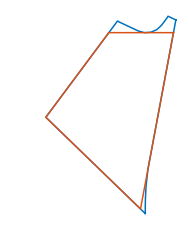

In [20]:
newVertices = makeSimpleCs3Bndry(clsdBP)
colorNum = 5
printBoundaryClr(clsdBP, colorNum)
printBoundaryClr(newVertices, colorNum+1)
#plt.savefig("./figures/ConcaveBoundary.pdf", bbox_inches='tight')

(-1.0722076220940426,
 0.8912361943135312,
 -1.0859154832602076,
 0.8042251484643573)

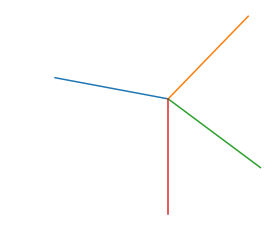

In [21]:
# Plot the Normals
BndryNormals = bndryNormals(newVertices)
for i in range(4):
    plt.plot([0,BndryNormals[i][0]], [0,BndryNormals[i][1]])

plt.axis('scaled')                      # Trim the white space
plt.axis('off')                         # Turn off the framing
#plt.savefig("./figures/FaceNormals.pdf", bbox_inches='tight')

[1928.62600199 2316.30228801  773.10174975 1444.21601523 3206.60273465
   40.62666159  453.4071151  3060.34303747 1106.13305133 1072.78996833
 2406.82545463 3596.06716278  633.95639885 1260.73085234 2869.19135136
 3768.45739961  292.15659233 4896.87022997 1358.31275503 -232.20815659
 1167.94814727 2097.71694916 1792.88353818 2336.44713467 3148.405453
  491.61238856  284.80767207 2577.33022816   17.34599942 4683.10903739
 1797.80534554  249.00497028 1806.34903099 1289.7660727  1459.78750749
 2756.17276517  724.91277603 2723.28082817 1989.8416656  1968.71313561
  761.48296407  258.58685148 3245.97350677 4843.26663196 2274.12468095
 2514.50200102  257.75932449  922.37362327 2046.22294685  601.27112832
 1537.59210902 3367.56800419  440.03124485 3795.46775873 1763.23733271
  942.61882932  115.78034833 2526.85692157 2817.73498723 2708.39734591
 1876.77435747 3563.32431126  177.21180955   17.64493496 2761.14516056
  990.68613797  482.1410167  2312.15637481  948.48207215 2888.04246956
 1637.11

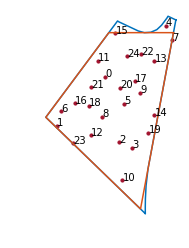

In [39]:
#-- Check turbines are in bounds --#
BndryNormals = bndryNormals(newVertices)
x0 = makeCoordArray(turbRandoList)
faceDist = calcDistNorms(x0, newVertices, BndryNormals)
#np.set_printoptions(suppress=True)
print(faceDist)
#print(faceDist.flatten())
#print(bInside)

printBoundaryClr(clsdBP, colorNum)
#printTurbines(clsdBP, getPltClrs().getColor(5), 10) # Print the boundary verticies
printBoundaryClr(newVertices, colorNum+1)
printTurbines(turbRandoList, getPltClrs().getColor(1), 10, True)
#plt.savefig("./figures/BoundaryNumberedTurbs.pdf", bbox_inches='tight')

### Spacing Constraint
`0600.09.Apr.20` I think there is a problem with my `checkTurbSpacing` function last time. I'll redo and check it here.

`1200.15.Apr.20` Fixed.

In [51]:
#-- Rewrite of checkTurbSpacing() --#
from scipy.special import binom   # For calculating the number of combinations

def checkTurbSpacingTEST(turbCoords, fMinTurbDist):
    #-- Returns an array of the distance between every pair of coordinates
    #-- turbCoords should be of <coordinate> type.
    nNumTurbs = len(turbCoords)         # Our number of turbines
    nNumPairs = int(binom(nNumTurbs, 2))# Number of unique turb pairs > C(nTurbs, 2) = nTurbs! / (2*(nTurbs-2)!).
    cTurbSpace = np.zeros(nNumPairs)    # Array holding the dist. between each pair
    
    nCntr = 0  # Logs where on the list we are
    for i in range(nNumTurbs):          # For every turbine
        for j in range((i+1), numTurbs):# Check the pairs we haven't calculated
            cTurbSpace[nCntr] = coordDist(turbCoords[i], turbCoords[j])
            nCntr = nCntr + 1

    constraints = cTurbSpace - fMinTurbDist    # Constrain that the turbines are less than 2 diams apart
    return constraints  # Negative if ok, positive if too close


In [75]:
#-- Validation of new checkTurbineSpacing() --#
def nameTurbPairs(numTurbs):
    #- Make an array logging all pair numbers -#
    nNumPairs = int(binom(numTurbs, 2))
    sPairNames = ["" for x in range(nNumPairs)]
    nCntr = 0   # Just a counter to iterate where we are
    for i in range(numTurbs):
        for j in range((i+1), numTurbs):
            sPairNames[nCntr] =  str(i) + ', ' + str(j)
            nCntr = nCntr + 1

    #-- Print the pari names to check --#
    #for i in range(nNumPairs):
    #    print(sPairNames[i])
    #print()
    
    return sPairNames, nNumPairs

#-- Calculate spacing constraints --#
Randox0 = makeCoordArray(turbRandoList)
[fTurbSpacing, bSpace] = checkTurbSpacing(Randox0, fMinDist) # Get the turbine spacing constraints
sPairNames, nNumPairs = nameTurbPairs(numTurbs)               # Get the pair name list

[2793.26129797  406.56754719 1841.65873703 1152.98282815 2017.89127981
 3185.34774687 1855.35542737 2900.17443575 3826.68191282 1779.93411408
 2345.03718022 2288.66179675 2250.23840926 1941.42740544 2311.0198944
  998.2225758  1311.21572071 2533.83519231  291.66116635 1290.28146354
 1605.14534145 3980.41621002  669.00520454  688.57162661 3202.96630499
 2634.06317923 1294.95345334  941.77728234  375.57615011  655.38290268
  114.96370498  647.38826655 2034.50181746  147.58566979 1368.30715738
 1887.11779822 4428.88177259 2669.34198536 2251.83045443 3754.0457151
  874.15689551 2249.575168   3403.51622904  794.96926701  885.95110021
 1843.56942835 1894.08577227 1425.9624439  1513.92449641 2174.45401389
 3708.35205169 2392.82498046 3202.97960726 4245.54515116 1580.82579987
 2828.82058442 2284.34396618 2089.95404533 2473.08879608 1914.12682774
  811.85342447 1933.70600856 2658.0045342   574.59581154 2007.40251689
 2031.70036935 4454.77113119 1343.49872076  914.24476268 1443.9992929
 1297.688

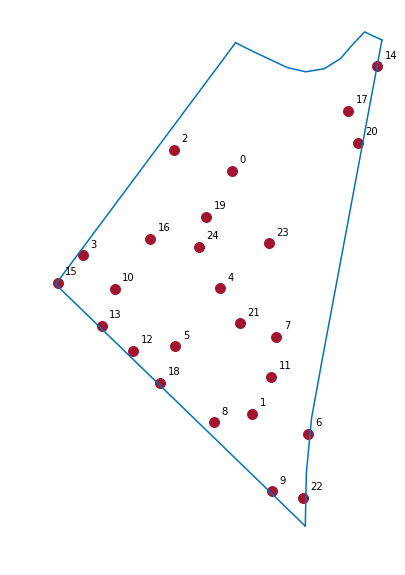

In [77]:
#---- Validation ----#
plt.figure(figsize=(20,10))
#-- Plot the boundary --#
for i in range(numSides):
    plt.hold = True
    printBoundaryArray(segCoordList[i].x, splineList[i](segCoordList[i].x), 5)
#-- Print the Turbines --#
printTurbines(turbRandoList, getPltClrs().getColor(1), turb_diam/2, True)
#-- Manually check for negative values --#
#bSpacing = np.ones(nNumPairs) # Boolean array counting how many are too close
#nGood = 0   # Number of close pairs
#- Check which were negative -#
#for i in range(nNumPairs):
#    if (fTurbSpacing[i] < 0):
#        bSpacing[i] = False
#        nGood = nGood + 1

#-- Print if there are violations --#
for i in range(nNumPairs):
    if (bSpace[i] == False):
        print(sPairNames[i])
        print(fTurbSpacing[i])
        print()

print(fTurbSpacing)
#print(bSpace)
print()

#plt.savefig("./figures/NumberedTurbs.pdf", bbox_inches='tight')

`0940.09.Apr.20`

`checkTurbSpacing()` works. I commented out the part of `iea37cs3randomstarts()` that checks for spacing (the last `for` loop) and then ran the check, and it popped for the correct turbine pairs. Of note, it only checks each pair once. So if turb #1 and turb #5 are too close, it only logs one violation, not two.

`1133.15.Apr.20`

I was incorrect before. There definitely was a problem using the `ssd.pdist` function for checking spacing, it was giving false negatives. I hade to rewrite `checkTurbSpacing()` with a less efficient double for-loop to ensure it works correctly.

### Putting it all together

`0946.09.Apr.20` I've really just got to get this done.

Now that I'm sure the turbine spacing constraint works and the boundary constraint works, I've gotta code up the optimization.

`1423.09.Apr.20`

So after lab meeting, Dr.~Ning and PJ directed me to the [PyOptSparse Tutorial](https://github.com/mdolab/pyoptsparse/blob/master/doc/tutorial.rst) which instructs me how to setup the optimization. The previous ones I was looking at (with SNOPT v7 and PyOpt) were incorrect, which is why I was having problems.

They did a really smart thing I didn't know about to pass all the variables: they used a [`dict`](https://www.w3schools.com/python/python_dictionaries.asp) instead of one long string of variables. I was packing and unpacking values previously with my `optimoMakeArgTuples()` and `optimoStripArgTuples()`, but I should've just been passing the values aldeary tagges as a dictionary. Live and learn.


In [ ]:
def makeParamsDict(wind_dir_freq, wind_speeds, wind_speed_probs, \
                     wind_dir, turb_diam, turb_ci, turb_co, rated_ws, \
                     rated_pwr, fAEPscale, fTCscale, cncvNorms, cncvVerts):
    ieq37Dict = dict([('wind_dir_freq', wind_dir_freq), \
                      ('wind_speeds', wind_speeds), \
                      ('wind_speed_probs', wind_speed_probs), \
                      ('wind_dir', wind_dir), \
                      ('turb_diam', turb_diam), \
                      ('turb_ci', turb_ci), \
                      ('turb_co', turb_co), \
                      ('rated_ws', rated_ws), \
                      ('rated_pwr', rated_pwr), \
                      ('fAEPscale', fAEPscale), \
                      ('fTCscale', fTCscale), \
                      ('cncvNorms', cncvNorms), \
                      ('cncvVerts', cncvVerts)])

    return ieq37Dict


#--- Testing ---#
#-- Load Everything --#
fn = "iea37-boundary-cs3.yaml"
bndryPts = getTurbAtrbtCs3YAML(fn)      # Pull the boundary vertices
clsdBP = closeBndryList(bndryPts)       # repeat the first so it's 'closed'
cncvVerts = makeSimpleCs3Bndry(clsdBP)  # Make the simplified Concave shape
cncvNorms = bndryNormals(cncvVerts)   # Calculate the normals for the concave shape
#- Load the turbine and windrose atributes -#
fname_turb = "iea37-10mw.yaml"
fname_wr = "iea37-windrose-cs3.yaml"
wind_dir, wind_dir_freq, wind_speeds, wind_speed_probs, num_speed_bins, min_speed, max_speed = iea37aepC.getWindRoseYAML(fname_wr)
turb_ci, turb_co, rated_ws, rated_pwr, turb_diam = iea37aepC.getTurbAtrbtYAML(fname_turb)
turbCoords = turbRandoList    # Use the random locations calculated above
numTurbs = len(turbCoords)

fAEPscale = 1.0
fTCscale = 1.0

ParamsDict = makeParamsDict(wind_dir_freq, wind_speeds, wind_speed_probs, wind_dir, turb_diam, turb_ci, turb_co, rated_ws, rated_pwr, fAEPscale, fTCscale, cncvNorms, cncvVerts)
print("Dictionary Values:")
print("wdf: " + str(ParamsDict['wind_dir_freq']))
print("td:  " + str(ParamsDict['turb_diam']))
print("tci: " + str(ParamsDict['turb_ci']))
print("tco: " + str(ParamsDict['turb_co']))
print("rws: " + str(ParamsDict['rated_ws']))
print("rpr: " + str(ParamsDict['rated_pwr']))
print("AEP: " + str(ParamsDict['fAEPscale']))
print("TCs: " + str(ParamsDict['fTCscale']))
print("Normals: "+ str(ParamsDict['cncvNorms']))
print("BndryVerts: " + str(ParamsDict['cncvVerts']))



`1519.09.Apr.20`

Well the dictionary thing works. Might need some tweaks moving forward, but time to code up the optimization. 

Setup some of the bounds on the optimization variables:

In [ ]:
#-- Get bounds on (x,y) TC design variables --#
minTCx = min(xDict['cncvVerts'].x)
maxTCx = max(xDict['cncvVerts'].x)
minTCy = min(xDict['cncvVerts'].y)
maxTCy = max(xDict['cncvVerts'].y)
#- print values to check -#
print("x-min: " + str(minTCx))
print("x-max: " + str(maxTCx))
print("y-min: " + str(minTCy))
print("y-max: " + str(maxTCy))
print(xDict['cncvVerts'][0:4])

#-- print visual --#
newVertices = makeSimpleCs3Bndry(clsdBP)
colorNum = 5
printBoundaryClr(newVertices, colorNum)
printTurbines(newVertices[0:4], getPltClrs().getColor(6), 10, True)

`1003.16.Apr.20`

pyOptSparse is having problems with me passing a variable as a matrix, so I have to write a small function that'll append every row so it's a one-element array, then back again:

In [ ]:
#-- Helper Functions for Opt setup --#
def MatrixToArray(fMat):
    # Converts the given matrix of (m,n) dimensions into an
    # array of dimensions (1, m*n), as well as n for reassembly
    nCol = len(fMat)           # Save the number of columns
    fArray = fMat.flatten('F') # Append each row to the end of the previous
    
    return fArray, nCol

def ArrayToMatrix(fArray, nCol):
    # Converts the given array of dimensions (1, x) into a
    # matrix of (nCol, mod(x, nCol)) dimensions.
    fMat = fArray.reshape(nCol, -1).T
    
    return fMat

#-- Validation --#
[tempArray, tCol] = MatrixToArray(wind_speed_probs)
tempMat =  ArrayToMatrix(tempArray, tCol)

print(tempArray.shape)
print(tempMat.shape)

### Defunct Optimization setup
`16.Apr.20`

In [ ]:
#-- Setting up the dictionary function for the optimization --#

# Inputs needed:
# turbine coords, splines for walls (to check boundaries)
def cs3posObjFun(posDict):
    #- Target function (AEP calculation) -#
    
    Tx0m = np.zeros((len(posDict['xvals']),2))
    Tx0m[:,0] = posDict['xvals']
    Tx0m[:,1] = posDict['yvals']
    tempTurbCoords = makeFirstCoordStruct(Tx0m)
    fScaleFactorAEP = posDict['fAEPscale']
    nTurbs = len(Tx0m) # get the number of turbines
    nPairs = int(binom(nTurbs, 2)) # Number of unique turbine pairs
    funcs = {}
    wind_speed_probs = ArrayToMatrix(posDict['wsp_array'], posDict['nWspCols']) # Make it a matrix again
    AEP = iea37aepC.calcAEPcs3(Tx0m, posDict['wind_dir_freq'], posDict['wind_speeds'], wind_speed_probs, posDict['wind_dir'], posDict['turb_diam'], posDict['turb_ci'], posDict['turb_co'], posDict['rated_ws'], posDict['rated_pwr'])
    totAEP = np.sum(AEP)
    funcs['obj'] = - (totAEP / fScaleFactorAEP) # Negative to minimize
    
    #- Prep data for constraints -#
    fScaleFactorTurbLoc = posDict['fTCscale']
    funcs['bndry'] = calcDistNorms(x0s, posDict['cncvVerts'], posDict['cncvNorms'])
    funcs['spacing'] = checkTurbSpacing(x0s, 2*turb_diam)
    
    #- Constraints (Pairwise distance [C(numTurbs, 2)], and all boundary checks [4* numTurbs]) -#
    #nBndryCnstr = nTurbs * 4 # each turbine (25) has one constraint for each boundary (4)
    #nSpaceCnstr = nPairs
    #conval = [0]*(nBndryCnstr + nSpaceCnstr)
    # List all the boundary and spacing constraints
    #conval = np.concatenate(cnstrSpacing, nBndryCnstr)
    #funcs['con'] = conval
    
    fail = False

    return funcs, fail

Execute the optimization:

In [ ]:
#-- Testing it's set up right --#
from pyoptsparse import Optimization, SNOPT, pyOpt_solution, NSGA2

#- Necessary Constants -#
numTurbs = len(turbRandoList) # get the number of turbines
numPairs = int(binom(numTurbs, 2)) # Number of unique turbine pairs
minTCx = min(ParamsDict['cncvVerts'].x)
maxTCx = max(ParamsDict['cncvVerts'].x)
minTCy = min(ParamsDict['cncvVerts'].y)
maxTCy = max(ParamsDict['cncvVerts'].y)

testAEP = iea37aepC.calcAEPcs3(makeCoordMatrix(makeCoordArray(turbRandoList)), wind_dir_freq, wind_speeds, wind_speed_probs, wind_dir, turb_diam, turb_ci, turb_co, rated_ws, rated_pwr)
print("Straight AEP: " + str(sum(testAEP)))
[testFuncs,_]  = cs3posObjFun(xDict)
print("ObjFun AEP:   " + str(testFuncs['obj']))

optProb = Optimization('CaseStudy3', cs3posObjFun)
optProb.addObj('obj')
#-- Strip x- and y- turbine coordinates and treat them separately --#
optProb.addVarGroup('x-vals', numTurbs, type='c', lower=minTCx, upper=maxTCx, value =turbRandoList.x)
optProb.addVarGroup('y-vals', numTurbs, type='c', lower=minTCy, upper=maxTCy, value =turbRandoList.y)
#-- Add our constant variables --#
optProb.addVarGroup('wind_dir_freq', len(wind_dir_freq), lower=wind_dir_freq, upper=wind_dir_freq, value=wind_dir_freq)
optProb.addVarGroup('wind_speeds', len(wind_speeds), lower=wind_speeds, upper=wind_speeds, value=wind_speeds)
[wsp_array, nWspCols] = MatrixToArray(wind_speed_probs) # Make an array for the optimizer
optProb.addVarGroup('wsp_array', nWspCols, lower=wsp_array, upper=wsp_array, value=wsp_array)
optProb.addVarGroup('wind_dir', len(wind_dir), lower=wind_dir, upper=wind_dir, value=wind_dir)
optProb.addVar('turb_diam', lower=turb_diam, upper=turb_diam, value=turb_diam)
optProb.addVar('turb_ci', lower=turb_ci, upper=turb_ci, value=turb_ci)
optProb.addVar('turb_co', lower=turb_co, upper=turb_co, value=turb_co)
optProb.addVar('rated_ws', lower=rated_ws, upper=rated_ws, value=rated_ws)
optProb.addVar('rated_pwr', lower=rated_pwr, upper=rated_pwr, value=rated_pwr)

#-- add our boundary constraint --#
optProb.addConGroup('bndry', 4*numTurbs, lower=0.0, upper=None)
#-- add our spacing constrain --#
optProb.addConGroup('spacing', numPairs, lower=0.0, upper=None)
opt = SNOPT()
opt.setOption('Scale option',0)
opt.setOption('Iterations limit',1000000)
opt.setOption('Summary file','summary_grid.out')
opt.setOption('Major optimality tolerance',1.e-5)
opt.setOption('Major feasibility tolerance',1.e-6)

print(optProb)

In [ ]:
sol = opt(optProb)
print(sol)

`1224.15.Apr.20`

So the optimizaiton is setup mostly correct. I've initialied the turbine x/y locations and setup a space for the constraints, but still need to figure out how to actually tell the optimizer to calculate the constraints for boundary and spacing.

`1349.15.Apr.20`

I've hit a bit of a wall. The problem is telling the optimizer the not-design variables neeeded to evaluate the Obj function without making them global or making them alterable variables. I'll need to figure out how to put them in the dicitonary as fixed numbers.

`0943.16.Apr.20`

Thinking about it, I think the method for giving the optimizer the varibales (even constant ones) is just the `addVar()` function, and constraining the values on both the high and low end. It seems inefficient because I think the optimizer will try to perturb it every iteration, but going through the documentation, that's all I can surmise to do since the three examples I've seen don't use functions with non-perturbed variables that aren't hard-coded into the objective function.

[PyOptSparse Guide](https:/www.github.com/mdolab/pyoptsparse/blob/master/doc/guide.rst)

[PyOptSparse Tutorial](https://www.github.com/mdolab/pyoptsparse/blob/master/doc/tutorial.rst)

[PyOptSparse source code (well commented)](https://www.github.com/mdolab/pyoptsparse/blob/master/pyoptsparse/pyOpt_optimization.py)

Though I'm running into a problem with the matrix variables for the windrose. PyOptSparse seems to only like scalars or single-dimension arrays.

### Explanations of Alternate ways:

`1031.16.Apr.20`

#### Example by Dr Ning

`1031.16.Apr.20`

Talking with Dr. Ning, he suggested doing a wrapper. The pseudocode he gave:
```python
def f(x, params):
   ...
end

def runopt():
    params = ...
    function g(x) = f(x, params)
    optimize(g, x0)
end

``` 
"Anonymous" `lambda` funcitons

I'm going to start the code anew with this wrapper method:

#### Example given by Eduardo

`1848.16.Apr.20`

In [ ]:
def generate_fun(params):

    def fun(x):
        return x*params[0] + params[1]
    
    return fun

Fun = return x * 10 + 20

In [ ]:
params = (10, 20, 30)
myfun = generate_fun(params)

In [ ]:
myfun(1)

In [ ]:
myfun==generate_fun

In [ ]:
(1,2,3)[0]

In [ ]:
#-- My test attempt at Eduardo's Wrapper (incomplete) --#
def aepWrapper(ParamsDict):
    # ParamsDict is a dictionary of the necessary variables needed for AEP evaluation
    def getAEP(x0):
    # Makes the long function definition shorter for readability
    # x0 should be an array of turbine locations [x1, y1, x2, y2, ...]
        x0m = makeCoordMatrix(x)  # Make it a matrix for the target function to use
        f = iea37aepC.calcAEPcs3(x0m, ParamsDict['wind_dir_freq'], \
                                 ParamsDict['wind_speeds'], \
                                 ParamsDict['wind_speed_probs'], \
                                 ParamsDict['wind_dir'], \
                                 ParamsDict['turb_diam'], \
                                 ParamsDict['turb_ci'], \
                                 ParamsDict['turb_co'], \
                                 ParamsDict['rated_ws'], \
                                 ParamsDict['rated_pwr'])

        return f

### Wrapper attempt

`0823.20.Apr.20`

I still don't fully understand it, but I'm going to try Dr. Ning's method of setup he told me about at lab meeting. If that doesn't work, I'll try Eduardo's method.

In [36]:
# A helper function to make a dictionary of all the necessary constants for AEP calculation
def makeParamsDict(wind_dir_freq, wind_speeds, wind_speed_probs, \
                     wind_dir, turb_diam, turb_ci, turb_co, rated_ws, \
                     rated_pwr, fAEPscale, fTCscale, cncvNorms, cncvVerts):
    ieq37Dict = dict([('wind_dir_freq', wind_dir_freq), \
                      ('wind_speeds', wind_speeds), \
                      ('wind_speed_probs', wind_speed_probs), \
                      ('wind_dir', wind_dir), \
                      ('turb_diam', turb_diam), \
                      ('minTurbSpace', 2*turb_diam), \
                      ('turb_ci', turb_ci), \
                      ('turb_co', turb_co), \
                      ('rated_ws', rated_ws), \
                      ('rated_pwr', rated_pwr), \
                      ('fAEPscale', fAEPscale), \
                      ('fTCscale', fTCscale), \
                      ('cncvNorms', cncvNorms), \
                      ('cncvVerts', cncvVerts)])

    return ieq37Dict

In [32]:
#--- Initialization of optimization ---#
#-- Load the Boundary --#
fn = "iea37-boundary-cs3.yaml"
bndryPts = getTurbAtrbtCs3YAML(fn)      # Pull the boundary vertices
clsdBP = closeBndryList(bndryPts)       # repeat the first so it's 'closed'
cncvVerts = makeSimpleCs3Bndry(clsdBP)  # Make the simplified Concave shape
cncvNorms = bndryNormals(cncvVerts)     # Calculate the normals for the concave shape
#- Load the turbine and windrose atributes -#
fname_turb = "iea37-10mw.yaml"
fname_wr = "iea37-windrose-cs3.yaml"
wind_dir, wind_dir_freq, wind_speeds, wind_speed_probs, num_speed_bins, min_speed, max_speed = iea37aepC.getWindRoseYAML(fname_wr)
turb_ci, turb_co, rated_ws, rated_pwr, turb_diam = iea37aepC.getTurbAtrbtYAML(fname_turb)
fAEPscale = 1.0
fTCscale = 1.0
#- Make a dictionary for variable passing -#
#dictParams = makeParamsDict(wind_dir_freq, wind_speeds, wind_speed_probs, wind_dir, turb_diam, turb_ci, turb_co, rated_ws, rated_pwr, fAEPscale, fTCscale, cncvNorms, cncvVerts)

turbCoords = makeCoordMatrix(turbRandoList)    # Use the random locations calculated previously


In [37]:
#-- Working the wrapper method --#
from pyoptsparse import Optimization, SNOPT, pyOpt_solution, NSGA2

def f(ParamsDict):
    # To follow Dr. Ning's rubric
    return lambda x0: iea37aepC.calcAEPcs3(x0, ParamsDict['wind_dir_freq'], \
                               ParamsDict['wind_speeds'], \
                               ParamsDict['wind_speed_probs'], \
                               ParamsDict['wind_dir'], \
                               ParamsDict['turb_diam'], \
                               ParamsDict['turb_ci'], \
                               ParamsDict['turb_co'], \
                               ParamsDict['rated_ws'], \
                               ParamsDict['rated_pwr'])


#def objfunc(xdict):
#    x0 = xdict['aTurbCoords']
#    funcs = {}
#    funcs['obj'] = getAEP(x0, params)
#    funcs['con'] = getTurbSpacing(x0)
#    fail = False

#    return funcs, fail

dictParams = makeParamsDict(wind_dir_freq, wind_speeds, wind_speed_probs, wind_dir, turb_diam, turb_ci, turb_co, rated_ws, rated_pwr, fAEPscale, fTCscale, cncvNorms, cncvVerts)
g = f(dictParams)

print(g(turbCoords))

[20985.45233705 14057.18375538 13262.15318612 13671.25811308
 17687.95364387 31672.96687597 46495.99141429 52013.35166082
 41606.39719507 41433.71720334 55871.42649351 61876.41038591
 69953.43824971 72505.65062041 66022.9912182  65518.7329799
 65842.61845374 65935.37016229 53533.63134644 35134.34535391]


`0943.20.Apr.20`

So I think I got Dr. Ning's `lambda` syntax functioning to calculate AEP given only the turbine locations. It doesn't really make sense to me, and I think it's still using global variables (which are dangerous), but I can't see another way to code it up in Python.

Now to code up the rest of the PyOptSparse syntax so it actually optimizes:

In [38]:
#-- Setting up the dictionary function for the optimization --#

# Inputs needed:
# turbine coords, splines for walls (to check boundaries)
def cs3posObjFun(coordDict):
    #- Target function (AEP calculation) -#
    
    x0m = makeArrayMatrix(coordDict['coordArray'])  # Turn our array of turb coords into a matrix for manipulation
    #fScaleFactorAEP = posDict['fAEPscale']
    nTurbs = len(x0m) # get the number of turbines
    nPairs = int(binom(nTurbs, 2)) # Number of unique turbine pairs
    funcs = {}
    AEP = g(x0m)
    totAEP = np.sum(AEP)
    funcs['obj'] = - (totAEP)# / fScaleFactorAEP) # Negative to minimize
    
    #- Prep data for constraints -#
    #fScaleFactorTurbLoc = posDict['fTCscale']
    x0s = makeMatrixCoord(x0m)
    funcs['bndry'] = calcDistNorms(x0s, dictParams['cncvVerts'], dictParams['cncvNorms'])
    funcs['spacing'] = checkTurbSpacing(x0s, dictParams['minTurbSpace'])
    
    #- Constraints (Pairwise distance [C(numTurbs, 2)], and all boundary checks [4* numTurbs]) -#
    #nBndryCnstr = nTurbs * 4 # each turbine (25) has one constraint for each boundary (4)
    #nSpaceCnstr = nPairs
    #conval = [0]*(nBndryCnstr + nSpaceCnstr)
    # List all the boundary and spacing constraints
    #conval = np.concatenate(cnstrSpacing, nBndryCnstr)
    #funcs['con'] = conval
    
    fail = False

    return funcs, fail

In [ ]:
%run 'baker_cs34_SNOPT_functions.py'

`1015.20.Apr.20`

This is getting a bit sloppy right now, so I'm going to break off into a different notebook.

# ToDo:

Scale AEP for optimizer.
Scale Turbine Coordinates for optimizer